[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/asteroid-team/asteroid/blob/master/notebooks/02_Filterbank.ipynb)

# Filterbank API
All supported filterbanks and related functions and classes can be found in [`asteroid_filterbanks`](https://github.com/asteroid-team/asteroid-filterbanks). The main classes are `Filterbank`, `Encoder` and `Decoder`.
- `Filterbank` is the class holding the properties of the filterbank you want to use.
- `Encoder` and `Decoder` are wrappers around filterbanks that enhance them with useful methods and attributes.

The most common is the filterbank with fully learnable filters : `FreeFB`. Wrapping it by an `Encoder` makes it similar 
to a `nn.Conv1d`, wrapping it by a `Decoder` makes it similar to a `nn.ConvTranspose1d`.

In [ ]:
# First install asteroid and depencies
!pip install git+https://github.com/asteroid-team/asteroid.git@master --quiet


### After installing requirements, you need to Restart Runtime (Ctrl + M).

Else it will fail to import asteroid

In [1]:
%matplotlib inline

## Simple example

In [2]:
import torch
from asteroid_filterbanks.enc_dec import Filterbank, Encoder, Decoder
from asteroid_filterbanks import FreeFB
import matplotlib.pyplot as plt


In [3]:
# First, instantiate a filterbank
fb = FreeFB(n_filters=256, kernel_size=128, stride=64)
# Make an encoder out of it, forward some waveform through it.
encoder = Encoder(fb)
# Same for decoder (the filterbank doesn't need to be the same)
decoder_fb = FreeFB(n_filters=256, kernel_size=128, stride=64)
decoder = Decoder(decoder_fb)
waveform = torch.randn(1, 1, 32000)  # (batch, channel, wav_lenght)
# This would be the output of an adaptative/learnable front-end like in TasNet.
spec_like = encoder(waveform)
# Do whatever you want with it
modif_spec_like = (spec_like.pow(2) + 1).log()
# Go back in the time domain with the decoder.
out_waveform = decoder(modif_spec_like)

## Short-time Fourier Transform (STFT)
`asteroid` provide a filterbank for STFT (`STFTFB`) which yields STFT when used as an encoder and iSTFT as a decoder.

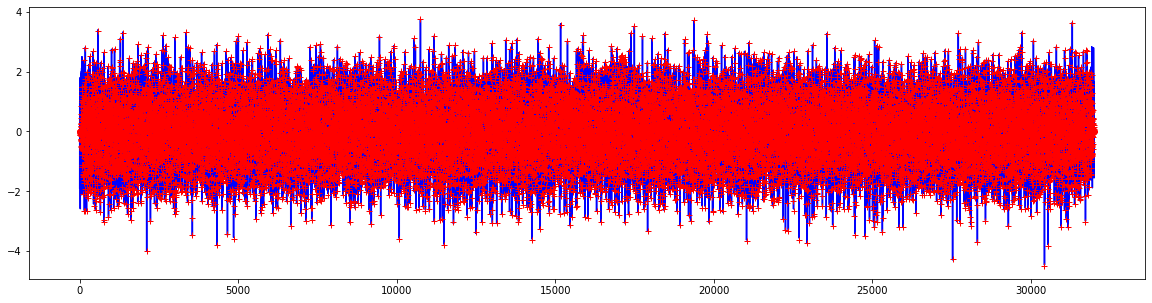

In [4]:
from asteroid_filterbanks import STFTFB
# By default, the filters are weighted by a square root hanning window.
dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(waveform)
out_waveform = istft(spec)

# We can plot to see the output is the same as the input.
fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(waveform.squeeze().data.numpy(), 'b')
axes.plot(out_waveform.squeeze().data.numpy(), 'r+')
plt.show()

## Dynamic pseudo-inverse
An `Decoder` can be a dynamic pseudo-inverse of an `Encoder` thanks to the `pinv_of` class method. The other way around also works.
Let's see and example of how simple this is and make some plots.

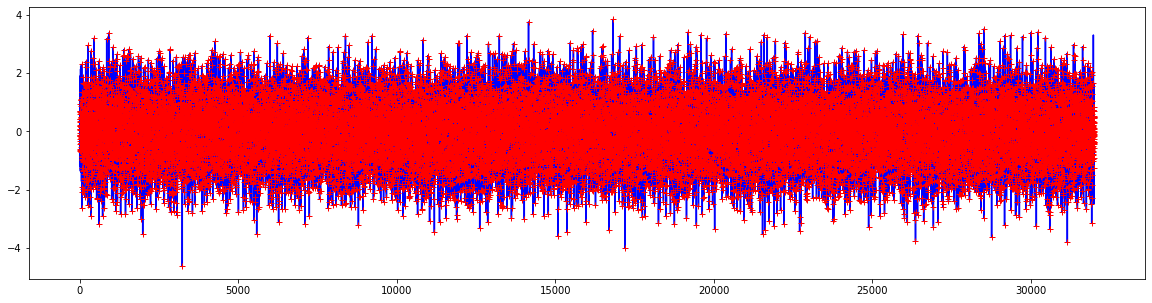

In [7]:
# Same as before, define a filterbank for an encoder.
fb = FreeFB(n_filters=256, kernel_size=128, stride=64)
encoder = Encoder(fb)
# Define the pseudo inverse decoder.
decoder = Decoder.pinv_of(encoder)

waveform = torch.randn(1, 1, 32000)  # (batch, channel, wav_lenght)
spec_like = encoder(waveform)
out_waveform = decoder(spec_like)

fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(waveform.squeeze().data.numpy(), 'b')
axes.plot(out_waveform.squeeze().data.numpy(), 'r+')
plt.show()

## Making an encoder-decoder pair in one line 
[`make_enc_dec`](https://github.com/asteroid-team/asteroid-filterbanks/blob/master/asteroid_filterbanks/__init__.py#L14-L70) is a small function that helps making encoder-decoder pairs in an efficient way. Let's see some examples :


In [93]:
from asteroid_filterbanks import make_enc_dec
# Create adaptative encoder-decoder pair like in Tasnet
enc, dec = make_enc_dec('free', n_filters=500, kernel_size=80)
# Create STFT/iSTFT pair in one line
stft, istft = make_enc_dec('stft', n_filters=512, kernel_size=256, stride=128)
# Create an analytic encoder and a pseudo-inverse decoder.
analytic_enc, pinv_dec = make_enc_dec('analytic_free', who_is_pinv='dec', n_filters=500, kernel_size=16, stride=8)

## Writing you own filterbank
You need to define a subclass of `Filterbank` and overwrite the `filters` property. 
Your filters can either be static or dynamic :
- Static filters are fixed at runtime (they can still be updated between forwards using gradient descent). This 
is the case of standard 1D-convolution or DFT filters for example.
- Dynamic filters depend on some internal variables and are computed on the go, for every forward.

In [94]:
class MyCoolFilterbank(Filterbank):
    def __init__(self, n_filters, kernel_size, stride=None,):
        super(MyCoolFilterbank, self).__init__(n_filters, kernel_size, stride=stride)
        # In case of static filters, assign it to `self._filters`, 
        # and return `self._filters` in the `filters` function.
        if your_filters_are_learnable:
            # Make them parameters
            self._filters = nn.Parameter(some_cool_filters)  # shape (n_filters, 1, kernel_size)
        elif your_filters_are_fixed:
            # Register them as buffer (enable automatic transfer to cuda and other things).
            self.register_buffer('_filters', some_cool_filters)
        
        # In case of dynamic filters, define the parameters you might need to compute them.
        self.some_parameter = nn.Parameter(learnable_parameter_your_filters_depend_on)
        
        # If the number of filters in the filterbank is different than the one requested by `n_filters`,
        # it can be specified with self.n_feats_out
        self.n_feats_out = some_function(n_filters)

    def filters(self):
        if your_filters_are_static:
            return self._filters
        elif your_filters_are_dynamic:
            # This will be called at every forward, you can compute your filters here.
            my_cool_filters = self.compute_filters(self.some_parameter)
            return my_cool_filters